#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### CHAPTER 22
**CH22A How does a merger between airlines affect prices?**

 using the airline-tickets-usa dataset
 
 version 1.0 2021-05-05

In [35]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyfixest as pf

warnings.filterwarnings("ignore")

In [36]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/airline-tickets-usa/clean/"
data_out = dirname + "da_case_studies/ch22-airline-merger-prices/"
output = dirname + "da_case_studies/ch22-airline-merger-prices/output/"

func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [37]:
# Import the prewritten helper functions
import py_helper_functions as da

# Set custom color scheme for plots
sns.set_theme(rc=da.da_theme, palette=da.color)

# I.  Examining pre-treatment trends in avg ln price

workfile to identify treated and untreated markets

In [38]:
# !!! make sure you have run ch22-airlines-01-dataprep.R before
data_work = pd.read_pickle(data_out + "ch22-airline-workfile.pkl").loc[
    lambda x: (x["balanced"] == 1) & (x["year"] == 2011)
][["origin", "finaldest", "return", "treated", "smallmkt"]]


use year-quarter panel data and merge to it treated-untreated 

(keep matched ones; no unmatched from "using")

In [39]:
data = pd.read_stata(data_in + "originfinal-panel.dta")
#data = pd.read_stata("https://osf.io/download/y3dfk/")

data = pd.merge(data, data_work, on=["origin", "finaldest", "return"])


aggreagete data to create average price by treated-untreated and year-quarter and draw time series graphs of log avg price all markets

In [40]:
weighted_avg = lambda x: np.average(x, weights=data.loc[x.index, "passengers"])


In [41]:
data_agg = (
    data.groupby(["treated", "year", "quarter"])
    .agg(avgprice=("avgprice", weighted_avg))
    .reset_index()
)

data_agg["lnavgprice"] = np.log(data_agg["avgprice"])

In [42]:
# Create the 'quarters' column as before
data_agg["quarters"] = (
    data_agg["year"].astype(str) + "Q" + data_agg["quarter"].astype(str)
)

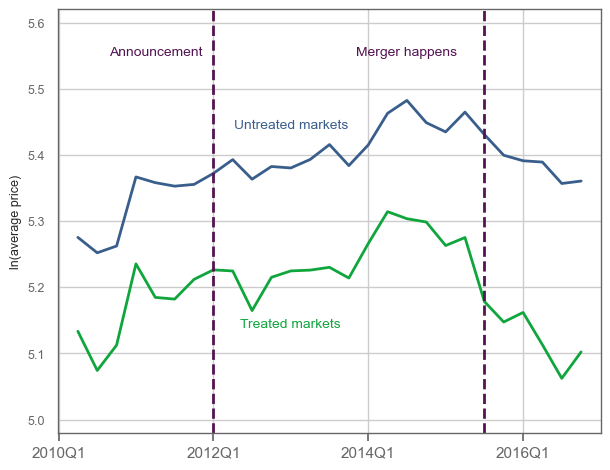

In [43]:
fig, ax = plt.subplots()

# Line plot for treated and untreated groups
sns.lineplot(
    data=pd.concat([pd.Series("2010Q1", name="quarters"), data_agg]),
    x="quarters",
    y="lnavgprice",
    hue="treated",
    linewidth=2,
    ax=ax,
)

# Add vertical lines for key events
ax.axvline(x="2012Q1", color=da.color[2], linestyle="--", linewidth=2)
ax.axvline(x="2015Q3", color=da.color[2], linestyle="--", linewidth=2)

# Annotate the plot
ax.text("2013Q1", 5.14, "Treated markets", color=da.color[1], fontsize=10, ha="center")
ax.text("2013Q1", 5.44, "Untreated markets", color=da.color[0], fontsize=10, ha="center")

ax.text("2011Q2", 5.55, "Announcement", color=da.color[2], fontsize=10, ha="center")
ax.text("2014Q3", 5.55, "Merger happens", color=da.color[2], fontsize=10, ha="center")

# Customize the x-axis and y-axis limits, ticks, and labels and remove the legend
ax.set_xticks(["2010Q1", "2012Q1", "2014Q1", "2016Q1"])
ax.set_ylim(4.98, 5.62)
ax.tick_params(axis="y", labelsize=9)
ax.set_ylabel("ln(average price)", fontsize=9)
ax.set_xlabel("", fontsize=9)
ax.legend_.remove()
da.add_margin(ax, x=-0.01, y=0)
plt.show()

**Small markets**

In [44]:
data_agg = (
    data.query("smallmkt == 1")
    .groupby(["treated", "year", "quarter"])
    .agg(avgprice=("avgprice", weighted_avg))
    .reset_index()
)

data_agg["lnavgprice"] = np.log(data_agg["avgprice"])
data_agg["quarters"] = (
    data_agg["year"].astype(str) + "Q" + data_agg["quarter"].astype(str)
)

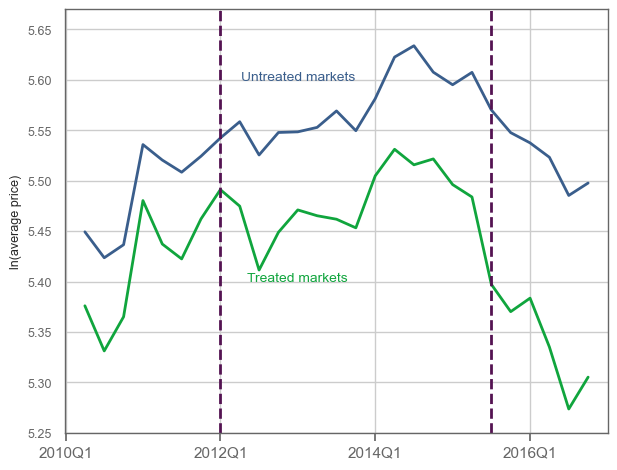

In [45]:
fig, ax = plt.subplots()

# Line plot for treated and untreated groups
sns.lineplot(
    data=pd.concat([pd.Series("2010Q1", name="quarters"), data_agg]),
    x="quarters",
    y="lnavgprice",
    hue="treated",
    linewidth=2,
    ax=ax,
)

# Add vertical lines for key events
ax.axvline(x="2012Q1", color=da.color[2], linestyle="--", linewidth=2)
ax.axvline(x="2015Q3", color=da.color[2], linestyle="--", linewidth=2)

# Annotate the plot
ax.text("2013Q1", 5.4, "Treated markets", color=da.color[1], fontsize=10, ha="center")
ax.text("2013Q1", 5.6, "Untreated markets", color=da.color[0], fontsize=10, ha="center")

# Customize the x-axis and y-axis limits, ticks, and labels and remove the legend
ax.set_xticks(["2010Q1", "2012Q1", "2014Q1", "2016Q1"])
ax.set_ylim(5.25, 5.67)
ax.tick_params(axis="y", labelsize=9)
ax.set_ylabel("ln(average price)", fontsize=9)
ax.set_xlabel("", fontsize=9)
ax.legend_.remove()
da.add_margin(ax, x=-0.01, y=0)
plt.show()

**Large markets**

In [46]:
data_agg = (
    data.query("smallmkt == 0")
    .groupby(["treated", "year", "quarter"])
    .agg(avgprice=("avgprice", weighted_avg))
    .reset_index()
)

data_agg["lnavgprice"] = np.log(data_agg["avgprice"])
data_agg["quarters"] = (
    data_agg["year"].astype(str) + "Q" + data_agg["quarter"].astype(str)
)

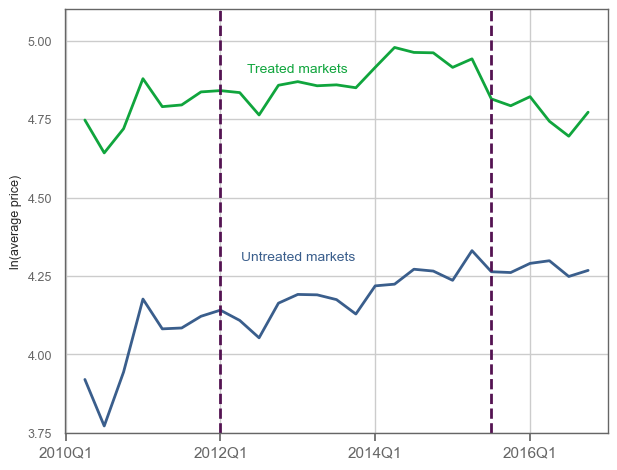

In [47]:
fig, ax = plt.subplots()

# Line plot for treated and untreated groups
sns.lineplot(
    data=pd.concat([pd.Series("2010Q1", name="quarters"), data_agg]),
    x="quarters",
    y="lnavgprice",
    hue="treated",
    linewidth=2,
    ax=ax,
)

# Add vertical lines for key events
ax.axvline(x="2012Q1", color=da.color[2], linestyle="--", linewidth=2)
ax.axvline(x="2015Q3", color=da.color[2], linestyle="--", linewidth=2)

# Annotate the plot
ax.text("2013Q1", 4.9, "Treated markets", color=da.color[1], fontsize=10, ha="center")
ax.text("2013Q1", 4.3, "Untreated markets", color=da.color[0], fontsize=10, ha="center")

# Customize the x-axis and y-axis limits, ticks, and labels and remove the legend
ax.set_xticks(["2010Q1", "2012Q1", "2014Q1", "2016Q1"])
ax.set_ylim(3.75, 5.1)
ax.set_yticks([3.75, 4, 4.25, 4.5, 4.75, 5])
ax.tick_params(axis="y", labelsize=9)
ax.set_ylabel("ln(average price)", fontsize=9)
ax.set_xlabel("", fontsize=9)
ax.legend_.remove()
da.add_margin(ax, x=-0.01, y=0)
plt.show()

# II. ANALYSIS
**Basic diff-in-diffs regression, weighted by # passengers on market, in before period**

In [48]:
# reload main file
data_agg = pd.read_pickle(data_out + "ch22-airline-workfile.pkl")
# keep balanced
data_balanced = data_agg.query("balanced == 1")


In [49]:
fd = pf.feols("d_lnavgp ~ treated", data_balanced, weights="pass_bef", vcov="hetero")
fd_small = pf.feols(
    "d_lnavgp ~ treated",
    data_balanced.loc[lambda x: x["smallmkt"] == 1],
    weights="pass_bef",
    vcov="hetero",
)
fd_large = pf.feols(
    "d_lnavgp ~ treated",
    data_balanced.loc[lambda x: x["smallmkt"] == 0],
    weights="pass_bef",
    vcov="hetero",
)

In [50]:
pf.etable(
    [fd, fd_small, fd_large],
    model_heads=["All markest", "Small markets", "Large markets"],
    head_order="h",
    show_se_type=False,
    labels={"Intercept": "Constant", "treated[T.True]": "AAUS<sub>before</sub>"},
    digits=2,
)

GT(_tbl_data=  level_0                level_1                     0                     1  \
0    coef  AAUS<sub>before</sub>  -0.18*** <br> (0.01)  -0.16*** <br> (0.01)   
1    coef               Constant   0.16*** <br> (0.01)   0.14*** <br> (0.01)   
2   stats           Observations                112632                111745   
3   stats          R<sup>2</sup>                  0.05                  0.04   
4   stats     Adj. R<sup>2</sup>                  0.05                  0.04   

                      2  
0  -0.26*** <br> (0.03)  
1   0.24*** <br> (0.02)  
2                   887  
3                  0.09  
4                  0.09  , _body=<great_tables._gt_data.Body object at 0x3e234bf20>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x3e23ad220>, _spanners=Spanners([SpannerInfo(spanner_id='All markest', spanner_level=1, spanner_label='All markest', spanner_units=None, spanner_pattern=None, vars=['0'], built=None), SpannerInfo(spanner_id='Small markets', spanner_level=1, spanner_label='Small markets', spanner_units=None, spanner_pattern=None, vars=['1'], built=None), SpannerInfo(spanner_id='Large markets', spanner_level=1, spanner_label='Large markets', spanner_units=None, spanner_pattern=None, vars=['2'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x3e23adca0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo

In [51]:
# Corresponding diff-in-diffs table
weighted_avg = lambda x: np.average(
    x,
    weights=data_balanced.loc[data_balanced["lnavgp"].notnull()].loc[
        x.index, "pass_bef"
    ],
)
data_balanced.loc[data_balanced["lnavgp"].notnull()].groupby(["after", "treated"]).agg(
    avgprice=("lnavgp", weighted_avg), n=("lnavgp", "count")
)


avgprice       n
after treated                  
0     False    4.926512  101275
      True     4.962715   11629
1     False    5.082928  101144
      True     4.939714   11628

**Diff-in-diffs regression with confounder variables weighted by # passengers on market, in before period**

In [52]:
data_balanced = data_balanced.merge(
    data_balanced.loc[lambda x: x["before"] == 1]
    .assign(
        lnpass=lambda x: np.log(x["passengers"]),
        sum_shares_bef=lambda x: x["shareAA"] + x["shareUS"],
    )
    .groupby("market")
    .agg(
        lnpass_bef=("lnpass", np.nanmean),
        share_bef=("sum_shares_bef", np.nanmean),
        sharelarge_bef=("sharelargest", np.nanmean),
    )
    .reset_index(),
    on="market",
)


In [53]:
data_balanced = data_balanced.rename(columns={"return": "return_"})


In [54]:
formula2 = "d_lnavgp ~ treated + lnpass_bef + return_ + stops + sharelarge_bef"
fd2 = pf.feols(formula2, data_balanced, weights="pass_bef", vcov="HC1")
fd2_small = pf.feols(
    formula2,
    data_balanced.loc[lambda x: x["smallmkt"] == 1],
    weights="pass_bef",
    vcov="HC1",
)
fd2_large = pf.feols(
    formula2,
    data_balanced.loc[lambda x: x["smallmkt"] == 0],
    weights="pass_bef",
    vcov="HC1",
)

In [55]:
pf.etable(
    [fd2, fd2_small, fd2_large],
    model_heads=["All markest", "Small markets", "Large markets"],
    head_order="h",
    show_se_type=False,
    labels={"Intercept": "Constant", "treated[T.True]": "AAUS<sub>before</sub>"},
    digits=2,
)

GT(_tbl_data=  level_0                level_1                     0                     1  \
0    coef  AAUS<sub>before</sub>  -0.11*** <br> (0.01)  -0.10*** <br> (0.01)   
1    coef             lnpass_bef     -0.00 <br> (0.00)      0.00 <br> (0.00)   
2    coef                return_   0.19*** <br> (0.01)   0.20*** <br> (0.01)   
3    coef                  stops   -0.03** <br> (0.01)      0.00 <br> (0.01)   
4    coef         sharelarge_bef   0.26*** <br> (0.02)   0.21*** <br> (0.02)   
5    coef               Constant  -0.15*** <br> (0.03)  -0.17*** <br> (0.02)   
6   stats           Observations                112632                111745   
7   stats          R<sup>2</sup>                  0.14                  0.11   
8   stats     Adj. R<sup>2</sup>                  0.14                  0.11   

                      2  
0  -0.13*** <br> (0.03)  
1    0.06** <br> (0.02)  
2   0.17*** <br> (0.03)  
3  -0.07*** <br> (0.02)  
4   0.43*** <br> (0.07)  
5  -0.74*** <br> (0.21)  
6                   887  
7                  0.23  
8                  0.23  , _body=<great_tables._gt_data.Body object at 0x3e2356fc0>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x3e2447c80>, _spanners=Spanners([SpannerInfo(spanner_id='All markest', spanner_level=1, spanner_label='All markest', spanner_units=None, spanner_pattern=None, vars=['0'], built=None), SpannerInfo(spanner_id='Small markets', spanner_level=1, spanner_label='Small markets', spanner_units=None, spanner_pattern=None, vars=['1'], built=None), SpannerInfo(spanner_id='Large markets', spanner_level=1, spanner_label='Large markets', spanner_units=None, spanner_pattern=None, vars=['2'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x3e243a2d0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value

**Diff-in-diffs regerssion with quantitative treatment weighted by # passengers on market, in before period**

In [56]:
share_bef_1 = np.where(data_balanced.query("before == 1")["share_bef"] == 1, 1, 0)
share_bef_0 = np.where(data_balanced.query("before == 1")["share_bef"] == 0, 1, 0)


In [57]:
data_balanced.query("before == 1").groupby([share_bef_0, share_bef_1]).agg(
    sum=("passengers", sum), mean=("passengers", "mean"), n=("passengers", "count")
)  # bit different from R


sum        mean      n
0 0  20169344  542.376207  37187
  1     34139    9.041049   3776
1 0   3746736   51.977360  72084

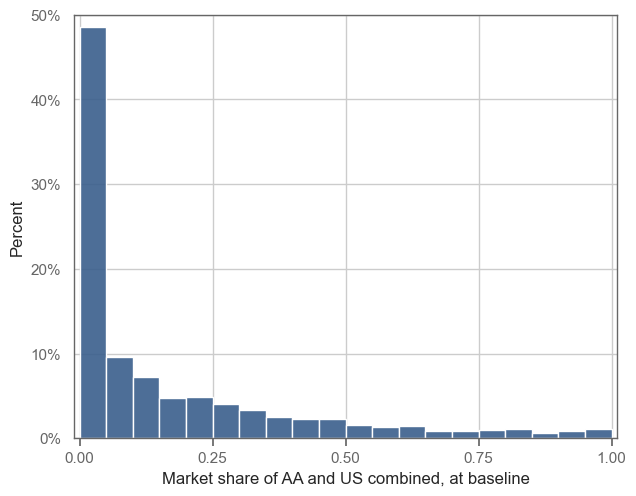

In [58]:
fig, ax = plt.subplots()

sns.histplot(
    data=data_balanced,
    x="share_bef",
    weights="pass_bef",
    binwidth=0.05,
    linewidth=1,
    alpha=0.9,
    stat="percent",
    ax=ax,
)

# Customize x-axis
ax.set_xlim(0, 1)
ax.set_xticks(np.arange(0, 1.25, 0.25))
ax.set_xlabel("Market share of AA and US combined, at baseline")

ax.set_ylim(0, 50)
ax.set_yticklabels([f"{int(t)}%" for t in ax.get_yticks()])  # Percent format
ax.set_ylabel("Percent")
da.add_margin(ax, x=0.01, y=0)
plt.show()

In [59]:
formula3 = "d_lnavgp ~ share_bef + lnpass_bef + return_ + stops + sharelarge_bef"
fd3 = pf.feols(formula3, data_balanced, weights="pass_bef", vcov="hetero")
fd3_small = pf.feols(
    formula3,
    data_balanced.loc[lambda x: x["smallmkt"] == 1],
    weights="pass_bef",
    vcov="hetero",
)
fd3_large = pf.feols(
    formula3,
    data_balanced.loc[lambda x: x["smallmkt"] == 0],
    weights="pass_bef",
    vcov="hetero",
)

In [60]:
pf.etable(
    [fd3, fd3_small, fd3_large],
    model_heads=["All markest", "Small markets", "Large markets"],
    head_order="h",
    show_se_type=False,
    labels={"Intercept": "Constant", "treated[T.True]": "AAUS<sub>before</sub>"},
    digits=2,
)

GT(_tbl_data=  level_0             level_1                     0                     1  \
0    coef           share_bef  -0.27*** <br> (0.02)  -0.17*** <br> (0.02)   
1    coef          lnpass_bef  -0.01*** <br> (0.00)  -0.01*** <br> (0.00)   
2    coef             return_   0.21*** <br> (0.01)   0.21*** <br> (0.01)   
3    coef               stops   -0.03** <br> (0.01)      0.00 <br> (0.01)   
4    coef      sharelarge_bef   0.31*** <br> (0.02)   0.26*** <br> (0.02)   
5    coef            Constant  -0.12*** <br> (0.03)  -0.15*** <br> (0.02)   
6   stats        Observations                112632                111745   
7   stats       R<sup>2</sup>                  0.15                  0.11   
8   stats  Adj. R<sup>2</sup>                  0.15                  0.11   

                      2  
0  -0.42*** <br> (0.05)  
1     0.05* <br> (0.02)  
2   0.19*** <br> (0.02)  
3  -0.07*** <br> (0.02)  
4   0.47*** <br> (0.05)  
5  -0.72*** <br> (0.20)  
6                   887  
7                  0.30  
8                  0.30  , _body=<great_tables._gt_data.Body object at 0x3e243ad20>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x3e22e1310>, _spanners=Spanners([SpannerInfo(spanner_id='All markest', spanner_level=1, spanner_label='All markest', spanner_units=None, spanner_pattern=None, vars=['0'], built=None), SpannerInfo(spanner_id='Small markets', spanner_level=1, spanner_label='Small markets', spanner_units=None, spanner_pattern=None, vars=['1'], built=None), SpannerInfo(spanner_id='Large markets', spanner_level=1, spanner_label='Large markets', spanner_units=None, spanner_pattern=None, vars=['2'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x3e22e3050>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_

**Diff-in-diffs on pooled cross-sections regression**
* use entire unbalanced panel
* errr... after only is dropped here see later
* weighted by # passengers on market, in before period

In [61]:
data_agg = data_agg.merge(
    data_agg.loc[lambda x: x["before"] == 1]
    .assign(lnpass_bef=lambda x: np.log(x["passengers"]))
    .groupby("market")
    .agg(
        lnpass_bef=("lnpass_bef", np.nanmean),
        sharelarge_bef=("sharelargest", np.nanmean),
    )
    .reset_index(),
    on="market",
    how="left",
)


In [62]:
data_agg.groupby(["balanced", "before"]).agg({"passengers": ["sum", "count"]})


passengers        
                       sum   count
balanced before                   
False    0          457978   22851
         1          103082   28665
True     0        30186202  113047
         1        23950219  113047

In [63]:
# treatment group defined if observed before only or both before and after


In [64]:
data_agg = data_agg.merge(
    data_agg.loc[lambda x: x["before"] == 1]
    .groupby("market")
    .agg(treatment=("AA_and_US", np.nanmean))
    .reset_index(),
    on="market",
)


In [65]:
data_agg["treatment_isna"] = data_agg["treatment"].isna()
data_agg.groupby(["treatment_isna", "balanced"]).agg({"passengers": ["sum", "count"]})


passengers        
                               sum   count
treatment_isna balanced                   
False          False        103082   28665
               True       54136421  226094

In [66]:
data_agg = data_agg.rename(columns={"return": "return_"})


In [67]:
# conditioning on observed confounders
formula4 = "lnavgp ~ (treatment + lnpass_bef + return_ + stops + sharelarge_bef)*after"

fd4 = pf.feols(formula4, data_agg, weights="pass_bef", vcov="hetero")
fd4_small = pf.feols(
    formula4,
    data_agg.loc[lambda x: x["smallmkt"] == 1],
    weights="pass_bef",
    vcov="hetero",
)
fd4_large = pf.feols(
    formula4,
    data_agg.loc[lambda x: x["smallmkt"] == 0],
    weights="pass_bef",
    vcov="hetero",
)

In [68]:
pf.etable(
    [fd4, fd4_small, fd4_large],
    model_heads=["All markest", "Small markets", "Large markets"],
    head_order="h",
    show_se_type=False,
    labels={"Intercept": "Constant"},
    digits=2,
)

GT(_tbl_data=   level_0                      level_1                     0  \
0     coef                    treatment   0.43*** <br> (0.02)   
1     coef                   lnpass_bef  -0.37*** <br> (0.01)   
2     coef                      return_   0.84*** <br> (0.02)   
3     coef                        stops    0.07** <br> (0.02)   
4     coef               sharelarge_bef  -1.45*** <br> (0.05)   
5     coef                        after    -0.19* <br> (0.08)   
6     coef       treatment &#215; after  -0.11*** <br> (0.03)   
7     coef      lnpass_bef &#215; after     -0.00 <br> (0.01)   
8     coef         return_ &#215; after   0.20*** <br> (0.02)   
9     coef           stops &#215; after      0.01 <br> (0.03)   
10    coef  sharelarge_bef &#215; after   0.30*** <br> (0.07)   
11    coef                     Constant   7.85*** <br> (0.06)   
12   stats                 Observations                254178   
13   stats                R<sup>2</sup>                  0.68   
14   stats           Adj. R<sup>2</sup>                  0.68   

                       1                     2  
0    0.29*** <br> (0.01)   0.69*** <br> (0.05)  
1   -0.30*** <br> (0.00)  -0.54*** <br> (0.05)  
2    0.84*** <br> (0.01)   0.95*** <br> (0.05)  
3    0.14*** <br> (0.01)      0.03 <br> (0.04)  
4   -1.38*** <br> (0.03)  -1.69*** <br> (0.13)  
5   -0.17*** <br> (0.04)     -0.82 <br> (0.57)  
6   -0.10*** <br> (0.02)    -0.14* <br> (0.07)  
7       0.00 <br> (0.00)      0.06 <br> (0.06)  
8    0.20*** <br> (0.01)     0.19* <br> (0.07)  
9       0.00 <br> (0.02)      0.01 <br> (0.06)  
10   0.21*** <br> (0.04)     0.44* <br> (0.18)  
11   7.36*** <br> (0.03)   9.23*** <br> (0.40)  
12                223902                  1774  
13                  0.68                  0.56  
14                  0.68                  0.55  , _body=<great_tables._gt_data.Body object at 0x3e22def00>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x3e22da9f0>, _spanners=Spanners([SpannerInfo(spanner_id='All markest', spanner_level=1, spanner_label='All markest', spanner_units=None, spanner_pattern=None, vars=['0'], built=None), SpannerInfo(spanner_id='Small markets', spanner_level=1, spanner_label='Small markets', spanner_units=None, spanner_pattern=None, vars=['1'], built=None), SpannerInfo(spanner_id='Large markets', spanner_level=1, spanner_label='Large markets', spanner_units=None, spanner_pattern=None, vars=['2'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x3e230ad50>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table